# V1228 Tau

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

First, let's take a look at the original light curve from the Kepler pipeline.

In [2]:
target = 'V1228 Tau'

search = lk.search_lightcurve(target, cadence='short', mission='K2')
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,K2 Campaign 04,2015,K2,60,ktwo211101694,0.0


In [3]:
og_lc = search.download()

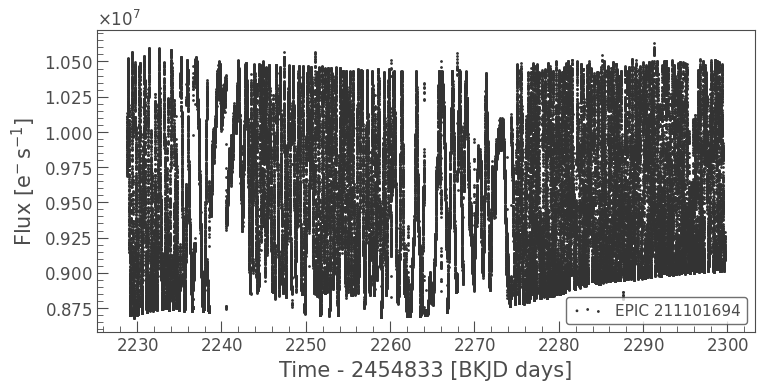

In [4]:
og_lc.scatter();

Ok, this light curve has some issues. Zooming in:

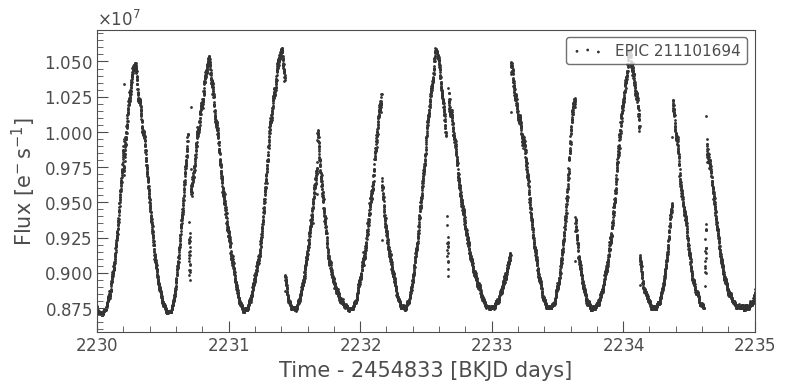

In [5]:
ax = og_lc.scatter()
ax.set_xlim(2230,2235);

While it looks like there's some sort of oscillation in here, it does not look stellar in origin. Does it perhaps correlate with the spacecraft motion?

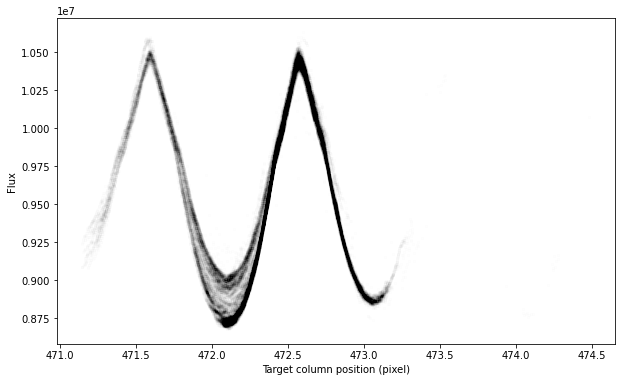

In [6]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

plt.plot(og_lc.centroid_col,og_lc.flux,'.', c='k',alpha=0.005)
plt.xlabel('Target column position (pixel)')
plt.ylabel('Flux')
plt.show()

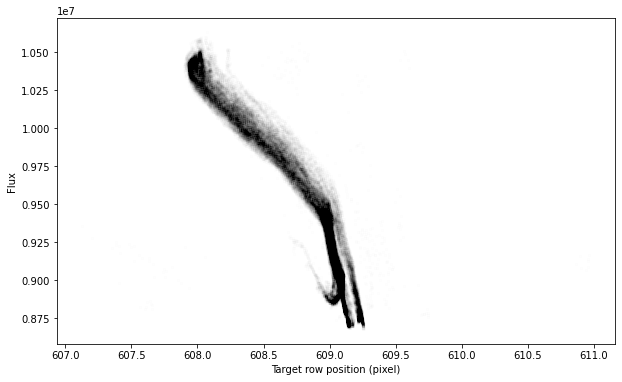

In [7]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

plt.plot(og_lc.centroid_row,og_lc.flux,'.', c='k',alpha=0.005)
plt.xlabel('Target row position (pixel)')
plt.ylabel('Flux')
plt.show()

Ah! There's something going on here! That the flux is changing with position suggests making a correction like the Self Flat-Fielding (SFF) method described by Vanderburg and Johnson (2014). However the behaviour of the flux with the motion is a bit more complex than the SFF corrector implementation in lightkurve can correct.

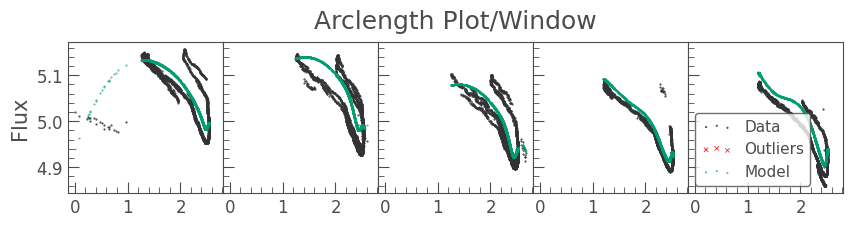

In [8]:
corrector = og_lc[:14251].remove_nans().to_corrector("sff")
corr_lc = corrector.correct(windows=5)
corrector.diagnose_arclength()

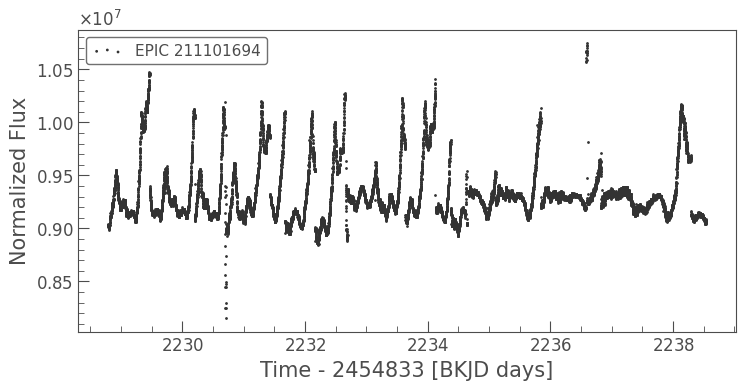

In [9]:
corr_lc.scatter();

Let's investigate the target pixel file to better understand what is happening.

In [10]:
search = lk.search_targetpixelfile(target, cadence='short', mission='K2')
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,K2 Campaign 04,2015,K2,60,ktwo211101694,0.0


In [11]:
tpf = search.download()

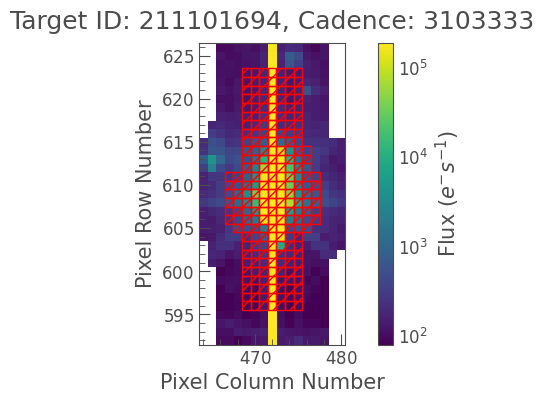

In [12]:
tpf[2550].plot(scale='log',aperture_mask=tpf.pipeline_mask);

We can see now that the pipeline aperture mask is too small for this target. Furthermore, the target pixel file is also too small. As a result, there are significant aperture losses, which change with the spacecraft motion. Because the TPF itself is too small, these aperture losses cannot be entirely mitigated by simply making the aperture mask larger. We can, however, make a better mask, and correct for the aperture losses using a SFF-like method.

Because the pointing drift behaviour changes throughout the observations, we break the light curve into several segments and perform the corrections separately.

In [13]:
#First segment
t1 = 0
t2 = 14251

#Create new aperture mask
mask = tpf[t1:t2].create_threshold_mask(threshold=5)

#Dilate mask to minimise aperture losses with spacecraft motion
mask = binary_dilation(mask,iterations=1)

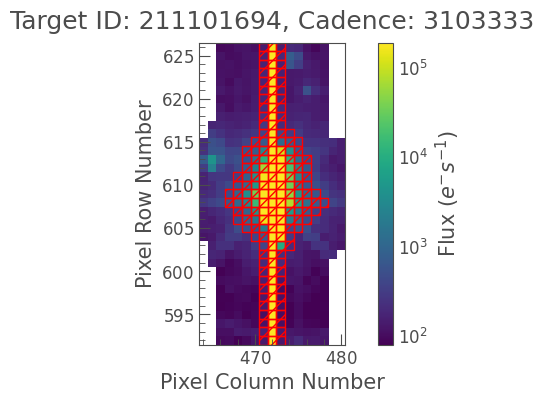

In [14]:
tpf[2550].plot(scale='log',aperture_mask=mask);

In [15]:
lc1 = tpf[t1:t2].to_lightcurve(aperture_mask = mask)

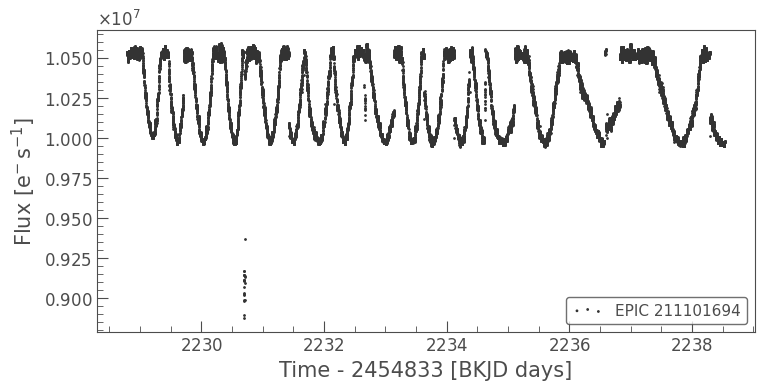

In [16]:
lc1.scatter();

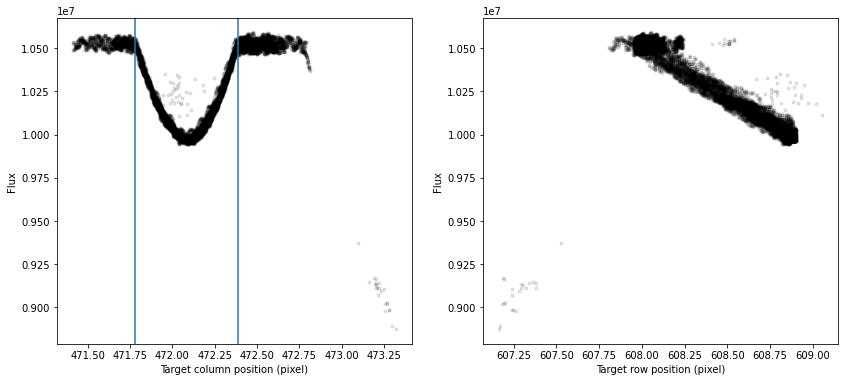

In [17]:
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(lc1.centroid_col,lc1.flux,'.', c='k',alpha=0.1)
ax[0].set_xlabel('Target column position (pixel)')
ax[0].set_ylabel('Flux')
ax[0].axvline(471.78)
ax[0].axvline(472.39)

ax[1].plot(lc1.centroid_row,lc1.flux,'.', c='k',alpha=0.1)
ax[1].set_xlabel('Target row position (pixel)')
ax[1].set_ylabel('Flux')

plt.show()

We can see now that for the first segment, with excpetion of a few outliers, the flux appears to change linearly with the target row position. Also, it is only cadences where the star is in a certain column range that need correction. We can fit and remove this trend.

In [18]:
centroid_mask = (lc1.centroid_col.value > 471.78) & (lc1.centroid_col.value < 472.39)

# Linear fit to trend:
z = np.polyfit(lc1[centroid_mask].centroid_row.value-608.1, lc1[centroid_mask].flux, 1)
p = np.poly1d(z)

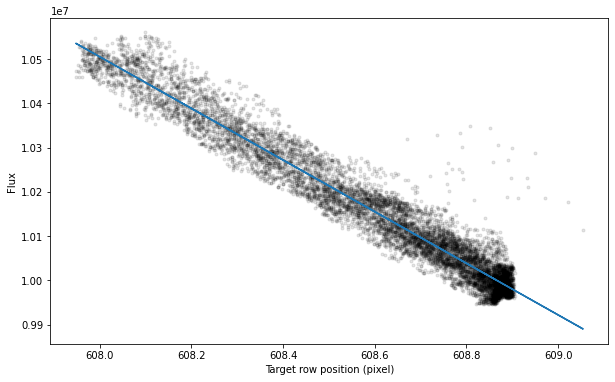

In [19]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

plt.plot(lc1[centroid_mask].centroid_row,lc1[centroid_mask].flux,'.', c='k',alpha=0.1)
plt.plot(lc1[centroid_mask].centroid_row, p(lc1[centroid_mask].centroid_row.value-608.1))
plt.xlabel('Target row position (pixel)')
plt.ylabel('Flux')

plt.show()

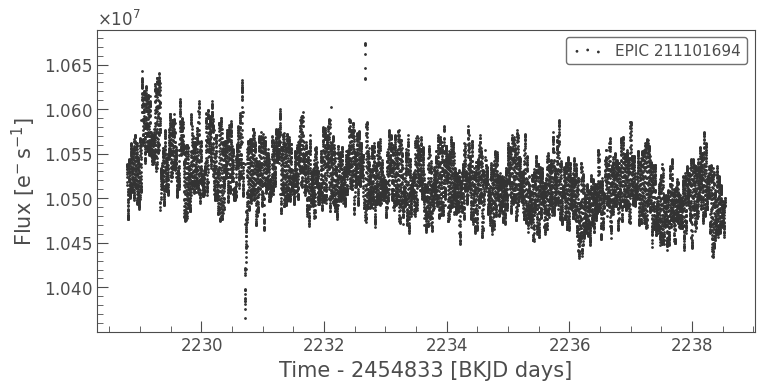

In [20]:
lc1.flux.value[centroid_mask] = lc1.flux[centroid_mask].value - (p(lc1.centroid_row[centroid_mask].value-608.1) - np.nanmedian(lc1.flux[~centroid_mask].value))

lc1.remove_outliers().scatter();

That is a significant improvement. We can do similarly for the second segment of the light curve:

In [21]:
#Second segment
t1 = 14251
t2 = 48530

#Create new aperture mask
mask = tpf[t1:t2].create_threshold_mask(threshold=5)

#Dilate mask to minimise aperture losses with spacecraft motion
mask = binary_dilation(mask,iterations=1)

#Ensure that bleed columns are always included
mask[:,7] = True
mask[:,8] = True
mask[:,9] = True

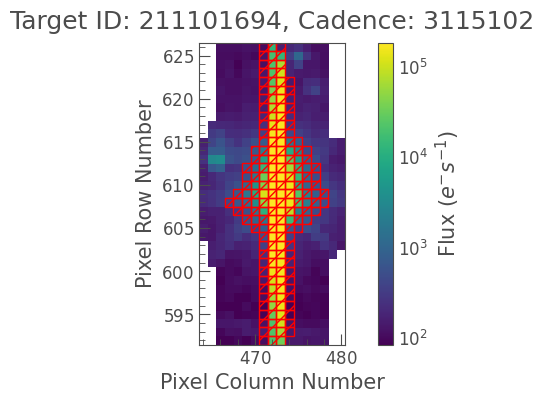

In [22]:
tpf[t1].plot(scale='log',aperture_mask=mask);

In [23]:
lc2 = tpf[t1:t2].to_lightcurve(aperture_mask = mask)

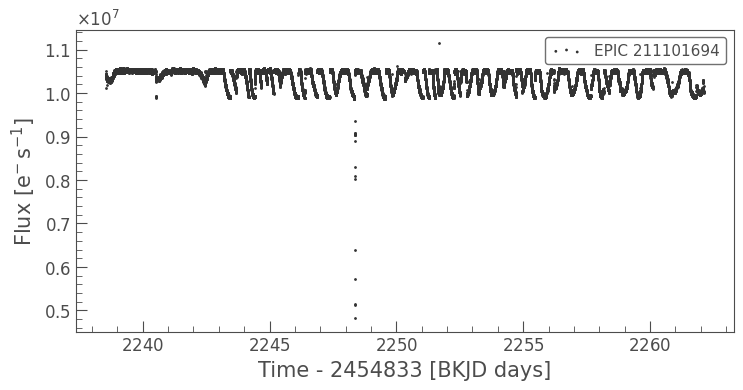

In [24]:
lc2.scatter();

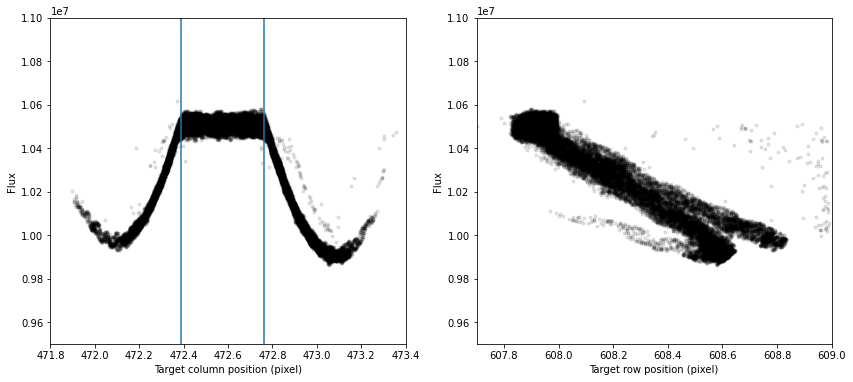

In [25]:
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(lc2.centroid_col,lc2.flux,'.', c='k',alpha=0.1)
ax[0].set_xlabel('Target column position (pixel)')
ax[0].set_ylabel('Flux')
ax[0].axvline(472.39)
ax[0].axvline(472.76)
ax[0].set_xlim(471.8,473.4)
ax[0].set_ylim(9.5e6,1.1e7)

ax[1].plot(lc2.centroid_row,lc2.flux,'.', c='k',alpha=0.1)
ax[1].set_xlabel('Target row position (pixel)')
ax[1].set_ylabel('Flux')
ax[1].set_xlim(607.7,609)
ax[1].set_ylim(9.5e6,1.1e7)

plt.show()

Here there are two drops in flux at when the star is centred on a different pixel. We will want to correct these drops separately.

In [26]:
centroid_mask_left = (lc2.centroid_col.value > 471.78) & (lc2.centroid_col.value <= 472.4)
centroid_mask_mid = (lc2.centroid_col.value > 472.4) & (lc2.centroid_col.value <= 472.76)
centroid_mask_right = (lc2.centroid_col.value > 472.76) & (lc2.centroid_col.value <= 473.27)

# Linear fit to trend 1:
z = np.polyfit(lc2[centroid_mask_left].centroid_row.value-608.1, lc2[centroid_mask_left].flux, 1)
p = np.poly1d(z)

# Remove trend 1 from light curve
lc2.flux.value[centroid_mask_left] = lc2.flux[centroid_mask_left].value - (p(lc2.centroid_row[centroid_mask_left].value-608.1) - np.nanmedian(lc2.flux[centroid_mask_mid].value))

# Linear fit to trend 2:
z = np.polyfit(lc2[centroid_mask_right].centroid_row.value-608.1, lc2[centroid_mask_right].flux, 1)
p = np.poly1d(z)

# Remove trend 2 from light curve
lc2.flux.value[centroid_mask_right] = lc2.flux[centroid_mask_right].value - (p(lc2.centroid_row[centroid_mask_right].value-608.1) - np.nanmedian(lc2.flux[centroid_mask_mid].value))


# A further correction
mask = ((lc2.centroid_col.value > 473.) & (lc2.centroid_col.value < 473.28)) & ((lc2.centroid_row.value < 609.) & (lc2.flux.value < 1.06e7))
z2 = np.polyfit(lc2.centroid_row[mask].value-608.1,lc2.flux[mask], 1)
p2 = np.poly1d(z2)

lc2.flux.value[mask] = lc2.flux[mask].value - (p2(lc2.centroid_row[mask].value-608.1) - np.nanmedian(lc2.flux[~mask].value))

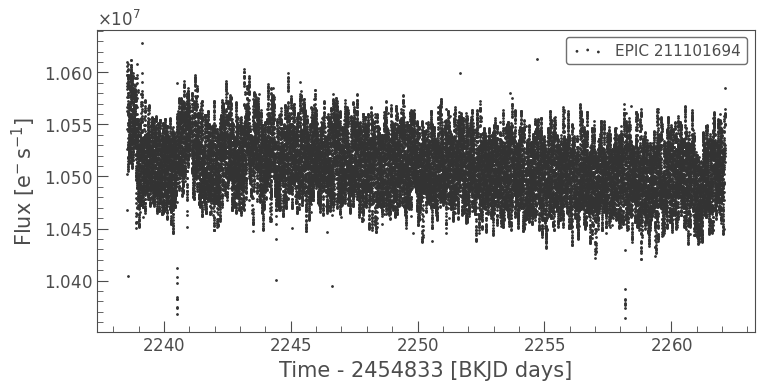

In [27]:
lc2.remove_outliers().scatter();

In [28]:
#Third segment
t1 = 48530
t2 = 62809

#Create new aperture mask
mask = tpf[t1:t2].create_threshold_mask(threshold=5)

#Dilate mask to minimise aperture losses with spacecraft motion
mask = binary_dilation(mask,iterations=1)

#Ensure that bleed columns are always included
mask[:,7] = True
mask[:,8] = True
mask[:,9] = True

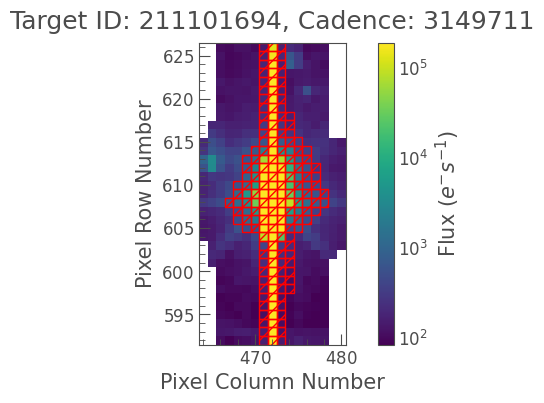

In [29]:
tpf[t1].plot(scale='log',aperture_mask=mask);

In [30]:
lc3 = tpf[t1:t2].to_lightcurve(aperture_mask = mask)

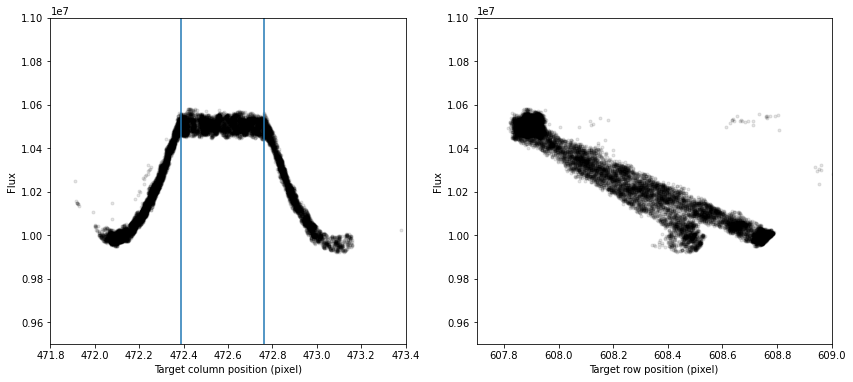

In [31]:
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(lc3.centroid_col,lc3.flux,'.', c='k',alpha=0.1)
ax[0].set_xlabel('Target column position (pixel)')
ax[0].set_ylabel('Flux')
ax[0].axvline(472.39)
ax[0].axvline(472.76)
ax[0].set_xlim(471.8,473.4)
ax[0].set_ylim(9.5e6,1.1e7)

ax[1].plot(lc3.centroid_row,lc3.flux,'.', c='k',alpha=0.1)
ax[1].set_xlabel('Target row position (pixel)')
ax[1].set_ylabel('Flux')
ax[1].set_xlim(607.7,609)
ax[1].set_ylim(9.5e6,1.1e7)

plt.show()

In [32]:
centroid_mask_left = (lc3.centroid_col.value > 471.78) & (lc3.centroid_col.value <= 472.39)
centroid_mask_mid = (lc3.centroid_col.value > 472.39) & (lc3.centroid_col.value <= 472.76)
centroid_mask_right = (lc3.centroid_col.value > 472.76) & (lc3.centroid_col.value <= 473.27)

# Linear fit to trend 1:
z = np.polyfit(lc3[centroid_mask_left].centroid_row.value-608.1, lc3[centroid_mask_left].flux, 1)
p = np.poly1d(z)

# Remove trend 1 from light curve
lc3.flux.value[centroid_mask_left] = lc3.flux[centroid_mask_left].value - (p(lc3.centroid_row[centroid_mask_left].value-608.1) - np.nanmedian(lc3.flux[centroid_mask_mid].value))

# Linear fit to trend 2:
z = np.polyfit(lc3[centroid_mask_right].centroid_row.value-608.1, lc3[centroid_mask_right].flux, 1)
p = np.poly1d(z)

# Remove trend 2 from light curve
lc3.flux.value[centroid_mask_right] = lc3.flux[centroid_mask_right].value - (p(lc3.centroid_row[centroid_mask_right].value-608.1) - np.nanmedian(lc3.flux[centroid_mask_mid].value))


# A further correction
mask = ((lc3.centroid_col.value > 473.) & (lc3.centroid_col.value < 473.28)) & ((lc3.centroid_row.value < 609.) & (lc3.flux.value < 1.06e7))
z2 = np.polyfit(lc3.centroid_row[mask].value-608.1,lc3.flux[mask], 1)
p2 = np.poly1d(z2)

lc3.flux.value[mask] = lc3.flux[mask].value - (p2(lc3.centroid_row[mask].value-608.1) - np.nanmedian(lc3.flux[~mask].value))

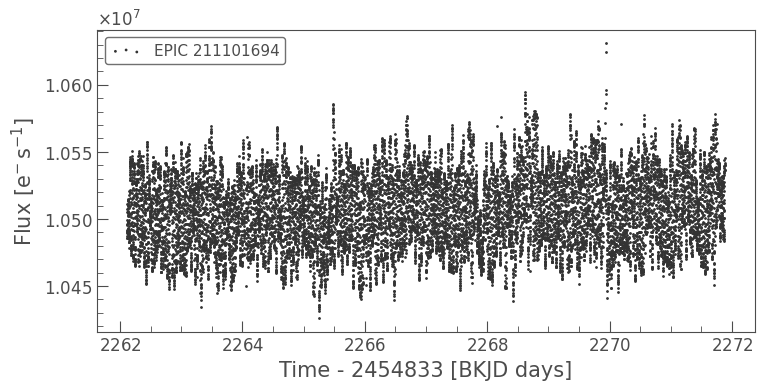

In [33]:
lc3.remove_outliers().scatter();

In [34]:
#Fourth segment
t1 = 62809
t2 = 66369

#Create new aperture mask
mask = tpf[t1:t2].create_threshold_mask(threshold=5)

#Dilate mask to minimise aperture losses with spacecraft motion
mask = binary_dilation(mask,iterations=1)

# #Ensure that bleed columns are always included
mask[:,7] = True
mask[:,8] = True
mask[:,9] = True

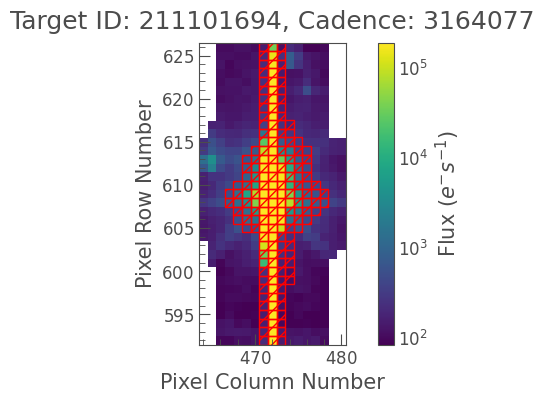

In [35]:
tpf[t1].plot(scale='log',aperture_mask=mask);

In [36]:
lc4 = tpf[t1:t2].to_lightcurve(aperture_mask = mask)

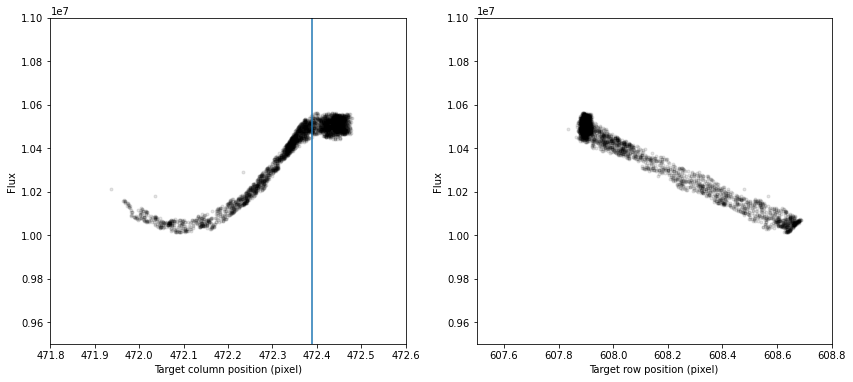

In [37]:
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(lc4.centroid_col,lc4.flux,'.', c='k',alpha=0.1)
ax[0].set_xlabel('Target column position (pixel)')
ax[0].set_ylabel('Flux')
ax[0].axvline(472.39)
ax[0].set_xlim(471.8,472.6)
ax[0].set_ylim(9.5e6,1.1e7)

ax[1].plot(lc4.centroid_row,lc4.flux,'.', c='k',alpha=0.1)
ax[1].set_xlabel('Target row position (pixel)')
ax[1].set_ylabel('Flux')
ax[1].set_xlim(607.5,608.8)
ax[1].set_ylim(9.5e6,1.1e7)

plt.show()

In [38]:
centroid_mask = lc4.centroid_col.value < 472.39

# Linear fit to trend:
z = np.polyfit(lc4[centroid_mask].centroid_row.value-608.1, lc4[centroid_mask].flux, 1)
p = np.poly1d(z)

# Remove trend from light curve
lc4.flux.value[centroid_mask] = lc4.flux[centroid_mask].value - (p(lc4.centroid_row[centroid_mask].value-608.1) - np.nanmedian(lc4.flux[~centroid_mask].value))

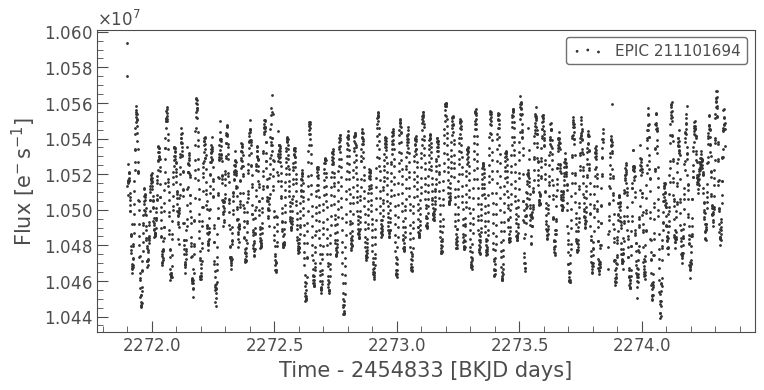

In [39]:
lc4.remove_outliers().scatter();

In [40]:
#Fifth segment
t1 = 66369
t2 = 67911

#Create new aperture mask
mask = tpf[t1:t2].create_threshold_mask(threshold=5)

#Dilate mask to minimise aperture losses with spacecraft motion
mask = binary_dilation(mask,iterations=1)

# #Ensure that bleed columns are always included
mask[:,7] = True
mask[:,8] = True
mask[:,9] = True

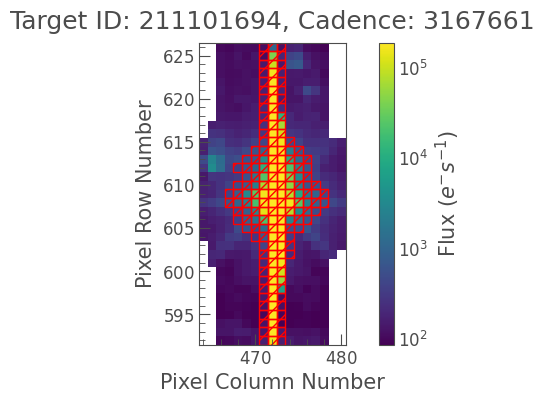

In [41]:
tpf[t1].plot(scale='log',aperture_mask=mask);

In [42]:
lc5 = tpf[t1:t2].to_lightcurve(aperture_mask = mask)

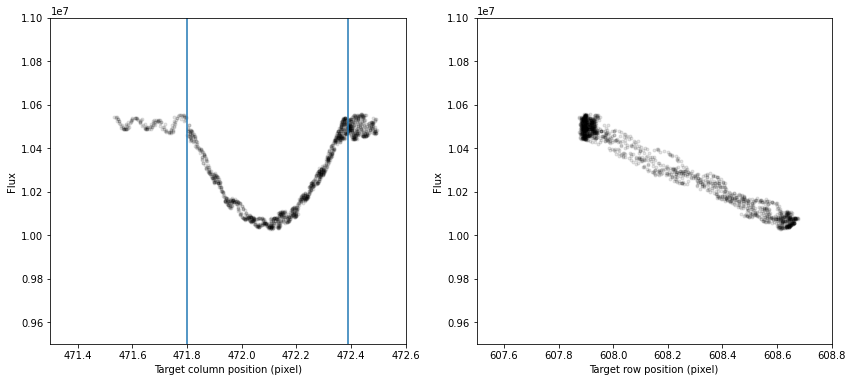

In [43]:
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(lc5.centroid_col,lc5.flux,'.', c='k',alpha=0.1)
ax[0].set_xlabel('Target column position (pixel)')
ax[0].set_ylabel('Flux')
ax[0].axvline(471.80)
ax[0].axvline(472.39)
ax[0].set_xlim(471.3,472.6)
ax[0].set_ylim(9.5e6,1.1e7)

ax[1].plot(lc5.centroid_row,lc5.flux,'.', c='k',alpha=0.1)
ax[1].set_xlabel('Target row position (pixel)')
ax[1].set_ylabel('Flux')
ax[1].set_xlim(607.5,608.8)
ax[1].set_ylim(9.5e6,1.1e7)

plt.show()

In [44]:
centroid_mask = (lc5.centroid_col.value > 471.8) & (lc5.centroid_col.value < 472.39)

# Linear fit to trend:
z = np.polyfit(lc5[centroid_mask].centroid_row.value-608.1, lc5[centroid_mask].flux, 1)
p = np.poly1d(z)

# Remove trend from light curve
lc5.flux.value[centroid_mask] = lc5.flux[centroid_mask].value - (p(lc5.centroid_row[centroid_mask].value-608.1) - np.nanmedian(lc5.flux[~centroid_mask].value))

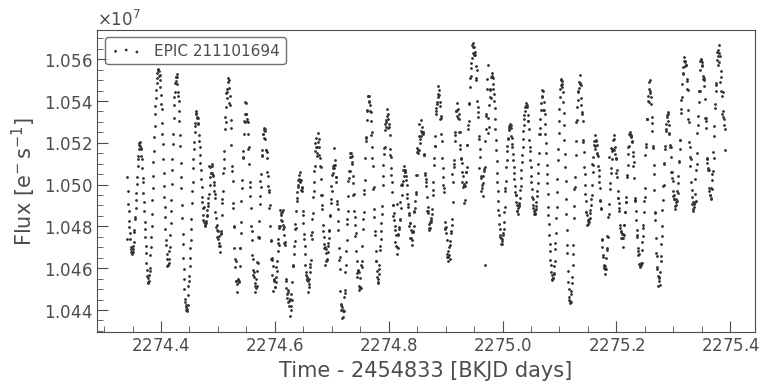

In [45]:
lc5.scatter();

In [46]:
#Sixth segment
t1 = 67911
t2 = 102720

#Create new aperture mask
mask = tpf[t1:t2].create_threshold_mask(threshold=5)

#Dilate mask to minimise aperture losses with spacecraft motion
mask = binary_dilation(mask,iterations=1)

# #Ensure that bleed columns are always included
mask[:,7] = True
mask[:,8] = True
mask[:,9] = True

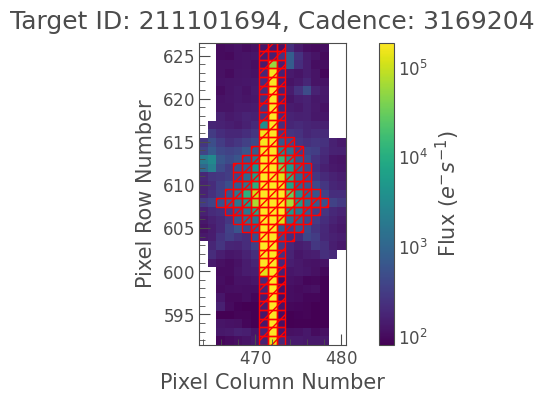

In [47]:
tpf[t1].plot(scale='log',aperture_mask=mask);

In [48]:
lc6 = tpf[t1:t2].to_lightcurve(aperture_mask = mask)

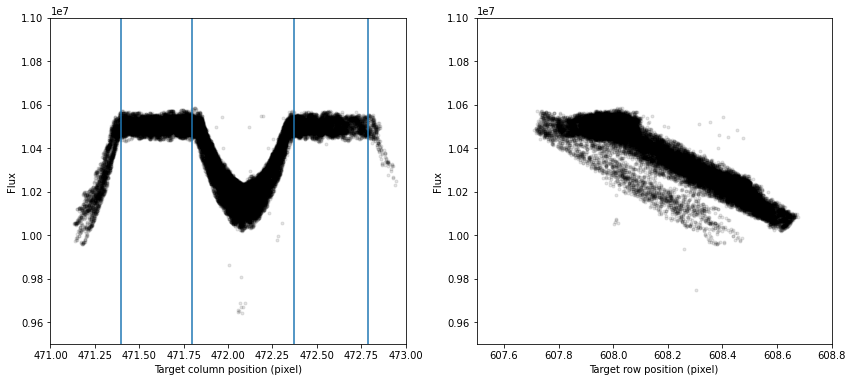

In [49]:
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(lc6.centroid_col,lc6.flux,'.', c='k',alpha=0.1)
ax[0].set_xlabel('Target column position (pixel)')
ax[0].set_ylabel('Flux')
ax[0].axvline(471.4)
ax[0].axvline(471.8)
ax[0].axvline(472.37)
ax[0].axvline(472.79)
ax[0].set_xlim(471,473.)
ax[0].set_ylim(9.5e6,1.1e7)

ax[1].plot(lc6.centroid_row,lc6.flux,'.', c='k',alpha=0.1)
ax[1].set_xlabel('Target row position (pixel)')
ax[1].set_ylabel('Flux')
ax[1].set_xlim(607.5,608.8)
ax[1].set_ylim(9.5e6,1.1e7)

plt.show()

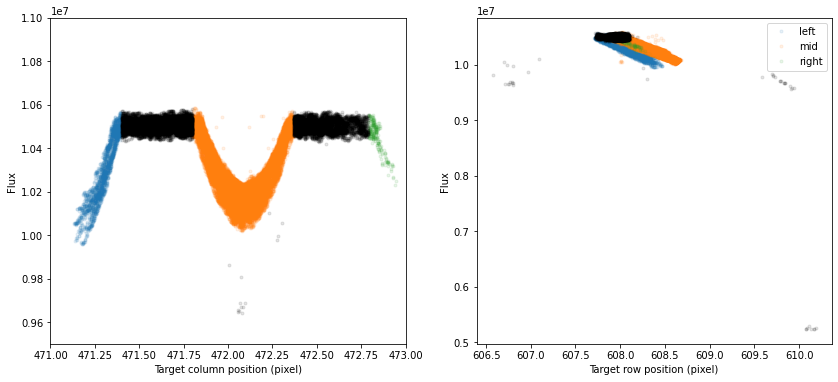

In [50]:
centroid_mask_left = (lc6.centroid_col.value < 471.4)
centroid_mask_mid = ((lc6.centroid_col.value > 471.8) & (lc6.centroid_col.value < 472.37)) & (lc6.centroid_row.value > 607.5)
centroid_mask_right = (lc6.centroid_col.value > 472.79) & (lc6.centroid_col.value < 473)
centroid_mask_remainder = ~(centroid_mask_left | centroid_mask_mid | centroid_mask_right)

fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(lc6.centroid_col[centroid_mask_left],lc6.flux[centroid_mask_left],'.',alpha=0.1,label='left')
ax[0].plot(lc6.centroid_col[centroid_mask_mid],lc6.flux[centroid_mask_mid],'.',alpha=0.1,label='mid')
ax[0].plot(lc6.centroid_col[centroid_mask_right],lc6.flux[centroid_mask_right],'.',alpha=0.1,label='right')
ax[0].plot(lc6.centroid_col[centroid_mask_remainder],lc6.flux[centroid_mask_remainder],'.', c='k',alpha=0.1)
ax[0].set_xlabel('Target column position (pixel)')
ax[0].set_ylabel('Flux')
ax[0].set_xlim(471,473.)
ax[0].set_ylim(9.5e6,1.1e7)

ax[1].plot(lc6.centroid_row[centroid_mask_left],lc6.flux[centroid_mask_left],'.',alpha=0.1,label='left')
ax[1].plot(lc6.centroid_row[centroid_mask_mid],lc6.flux[centroid_mask_mid],'.',alpha=0.1,label='mid')
ax[1].plot(lc6.centroid_row[centroid_mask_right],lc6.flux[centroid_mask_right],'.',alpha=0.1,label='right')
ax[1].plot(lc6.centroid_row[centroid_mask_remainder],lc6.flux[centroid_mask_remainder],'.', c='k',alpha=0.1)
ax[1].set_xlabel('Target row position (pixel)')
ax[1].set_ylabel('Flux')
# ax[1].set_xlim(607.5,608.8)
# ax[1].set_ylim(9.5e6,1.1e7)

ax[1].legend()
plt.show()

In [51]:
# Linear fit to trend 1:
z = np.polyfit(lc6[centroid_mask_left].centroid_row.value-608.1, lc6[centroid_mask_left].flux, 1)
p = np.poly1d(z)

# Remove trend 1 from light curve
lc6.flux.value[centroid_mask_left] = lc6.flux[centroid_mask_left].value - (p(lc6.centroid_row[centroid_mask_left].value-608.1) - np.nanmedian(lc6.flux[centroid_mask_remainder].value))

# Linear fit to trend 2:
z = np.polyfit(lc6[centroid_mask_mid].centroid_row.value-608.1, lc6[centroid_mask_mid].flux, 1)
p = np.poly1d(z)

# Remove trend 2 from light curve
lc6.flux.value[centroid_mask_mid] = lc6.flux[centroid_mask_mid].value - (p(lc6.centroid_row[centroid_mask_mid].value-608.1) - np.nanmedian(lc6.flux[centroid_mask_remainder].value))


# Linear fit to trend 3:
z = np.polyfit(lc6[centroid_mask_right].centroid_row.value-608.1, lc6[centroid_mask_right].flux, 1)
p = np.poly1d(z)

# Remove trend 2 from light curve
lc6.flux.value[centroid_mask_right] = lc6.flux[centroid_mask_right].value - (p(lc6.centroid_row[centroid_mask_right].value-608.1) - np.nanmedian(lc6.flux[centroid_mask_remainder].value))


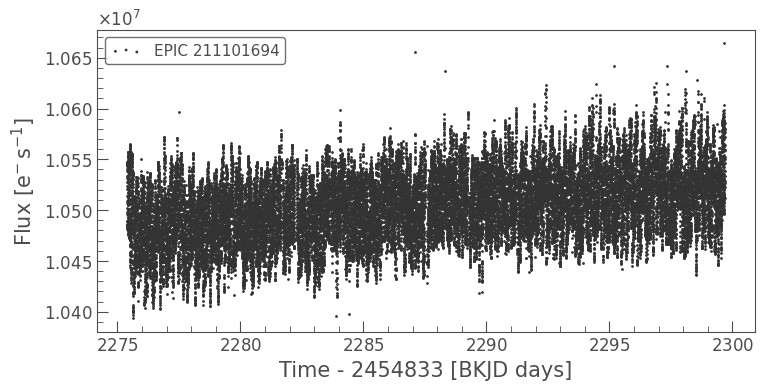

In [52]:
lc6.remove_outliers().scatter();

That's the last segment. Now to put them all together:

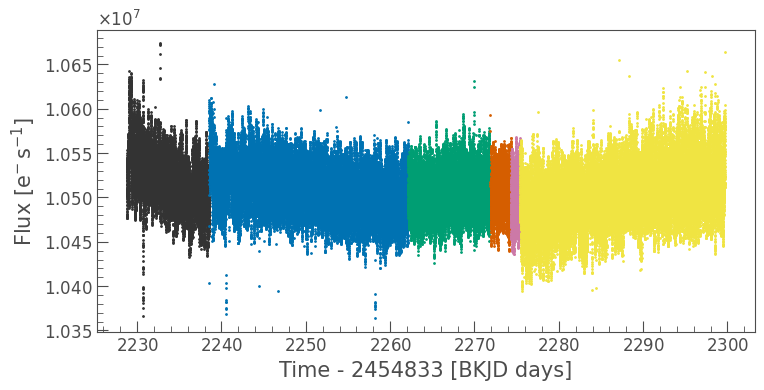

In [53]:
ax = lc1.remove_outliers().scatter(label='')
lc2.remove_outliers().scatter(ax=ax,label='')
lc3.remove_outliers().scatter(ax=ax,label='')
lc4.remove_outliers().scatter(ax=ax,label='')
lc5.remove_outliers().scatter(ax=ax,label='')
lc6.remove_outliers().scatter(ax=ax,label='');

We still have some residual trends that we can remove:

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

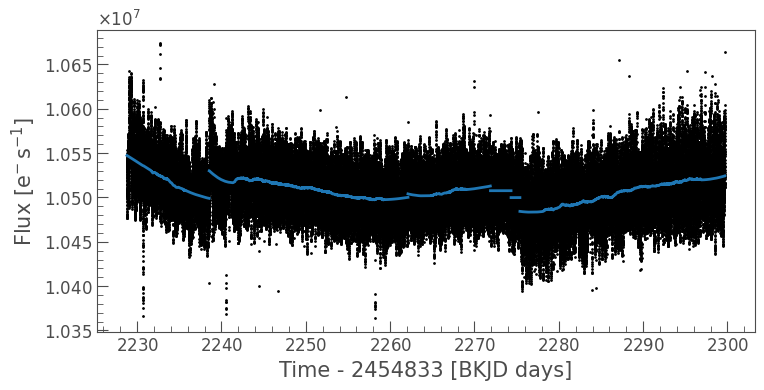

In [54]:
final_lc1,trend_lc1 = lc1.remove_outliers().flatten(window_length=8001,break_tolerance=None,return_trend=True)
final_lc2,trend_lc2 = lc2.remove_outliers().flatten(window_length=8001,break_tolerance=None,return_trend=True)
final_lc3,trend_lc3 = lc3.remove_outliers().flatten(window_length=8001,break_tolerance=None,return_trend=True)
final_lc4,trend_lc4 = lc4.remove_outliers().flatten(window_length=8001,break_tolerance=None,return_trend=True)
final_lc5,trend_lc5 = lc5.remove_outliers().flatten(window_length=8001,break_tolerance=None,return_trend=True)
final_lc6,trend_lc6 = lc6.remove_outliers().flatten(window_length=8001,break_tolerance=None,return_trend=True)

ax = lc1.remove_outliers().scatter(c='k',label='')
lc2.remove_outliers().scatter(c='k',ax=ax,label='')
lc3.remove_outliers().scatter(c='k',ax=ax,label='')
lc4.remove_outliers().scatter(c='k',ax=ax,label='')
lc5.remove_outliers().scatter(c='k',ax=ax,label='')
lc6.remove_outliers().scatter(c='k',ax=ax,label='')
trend_lc1.plot(ax=ax,linewidth=2,c='C0',label='')
trend_lc2.plot(ax=ax,linewidth=2,c='C0',label='')
trend_lc3.plot(ax=ax,linewidth=2,c='C0',label='')
trend_lc4.plot(ax=ax,linewidth=2,c='C0',label='')
trend_lc5.plot(ax=ax,linewidth=2,c='C0',label='')
trend_lc6.plot(ax=ax,linewidth=2,c='C0',label='')

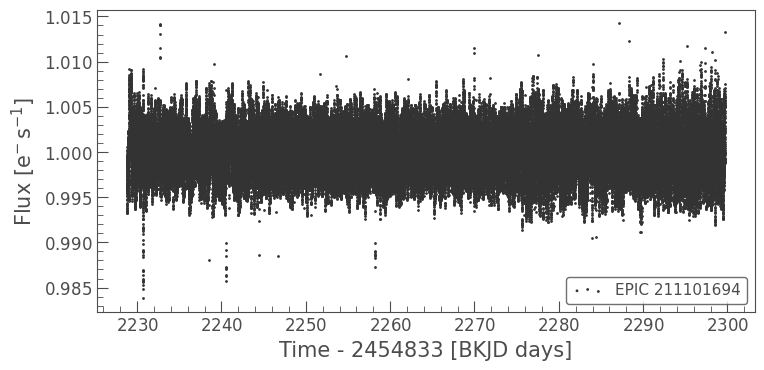

In [55]:
final_lc = final_lc1.append(final_lc2).append(final_lc3).append(final_lc4).append(final_lc5).append(final_lc6)
final_lc.scatter();

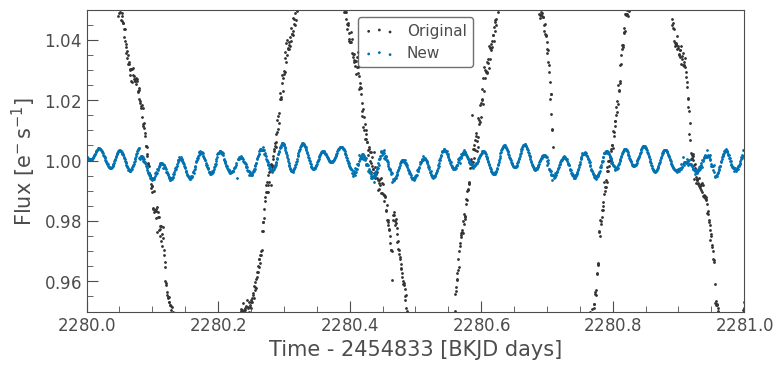

In [56]:
ax = og_lc.normalize().scatter(label='Original')
final_lc.scatter(ax=ax,label='New')
ax.set_ylim(0.95,1.05)
ax.set_xlim(2280,2281)
plt.show();

A much better light curve than we started with.

In [ ]:
final_lc.to_csv(path_or_buf='../lightcurves/V1228Tau_SC_C4_SYDSAP.csv')
final_lc.to_fits('../lightcurves/V1228Tau_SC_C4_SYDSAP.fits')